In [1]:
from preprocessor import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from keras import Sequential
from keras.layers import Dense
from collections import Counter

Using TensorFlow backend.


In [2]:
data = pd.read_csv('LoanPrediction/train_data.csv')


prep = Preprocessor(data)


prep.overview()


Dataset contains 614 rows and 13 columns

Data types of the raw (uncleaned) data:
Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object

Categorical features of the dataset: ['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area', 'Loan_Status']

Numeric features of the dataset: ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']

Checking for features with null values...

Credit_History       50
Self_Employed        32
LoanAmount           22
Dependents           15
Loan_Amount_Term     14
Gender               13
Married               3
Loan_Status           0
Property_Area   

In [3]:
df = data.dropna()
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
5,LP001011,Male,Yes,2,Graduate,Yes,5417,4196.0,267.0,360.0,1.0,Urban,Y


In [4]:
df = df.drop('Loan_ID',axis=1)

In [5]:

df['LoanAmount'] = (df['LoanAmount']*1000).astype(int)
print(Counter(df['Loan_Status']))
percentage = Counter(df['Loan_Status'])['Y'] / df['Loan_Status'].size
print(f'Percentage of approved loans in training dataset: {percentage:.3f} %')

Counter({'Y': 332, 'N': 148})
Percentage of approved loans in training dataset: 0.692 %


In [11]:
pre_y = df['Loan_Status']
pre_x = df.drop('Loan_Status',axis= 1)
dm_x = pd.get_dummies(pre_x)
dm_y = pre_y.map(dict(Y=1, N=0))


In [12]:
smote = SMOTE(ratio='minority')
X1, y = smote.fit_sample(dm_x, dm_y)
sc = MinMaxScaler()
X = sc.fit_transform(X1)


In [13]:
X_train, X_test, y_train ,y_test = train_test_split(X, y, random_state= 42,test_size = 0.2)

In [14]:
classifier = Sequential()
classifier.add(Dense(200, activation = 'relu', kernel_initializer='random_normal', input_dim=X_test.shape[1]))
classifier.add(Dense(400, activation='relu', kernel_initializer='random_normal'))
classifier.add(Dense(4, activation='relu', kernel_initializer='random_normal'))
classifier.add(Dense(1, activation='sigmoid', kernel_initializer='random_normal'))
classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
classifier.fit(X_train, y_train, batch_size=20,epochs=100, verbose=0)
eval_model = classifier.evaluate(X_train, y_train)
eval_model

531/531 [==============================] - 0s 116us/step


[0.6931313935197231, 0.5028248588131871]

In [47]:
y_pred = classifier.predict(X_test)
y_pred = (y_pred > 0.55)


[Text(0, 0.5, 'No'), Text(0, 1.5, 'Yes')]

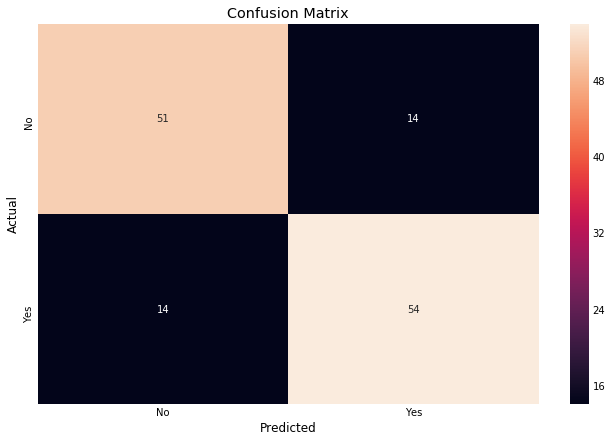

In [48]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,y_pred)
plt.figure(figsize=(10,7))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax =ax); #annot= True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted');ax.set_ylabel('Actual');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['No', 'Yes']); ax.yaxis.set_ticklabels(['No','Yes'])


In [49]:
import pickle
from sklearn.externals import joblib
filename = 'loan_model.pkl'
joblib.dump(classifier,filename)

/home/saazi/ml/env/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


['loan_model.pkl']

In [58]:
mdl = joblib.load('loan_model.pkl')
X=pd.read_csv('LoanPrediction/test_data.csv')
X.dropna(inplace = True)
X = X.drop('Loan_ID',axis=1)

X__dm_test = pd.get_dummies(X)

X_test = sc.fit_transform(X__dm_test)
y_pred = mdl.predict(X_test)
y_pred = (y_pred > 0.58)
X__dm_test.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender_Female,Gender_Male,Married_No,Married_Yes,Dependents_0,Dependents_1,Dependents_2,Dependents_3+,Education_Graduate,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
0,5720,0,110.0,360.0,1.0,0,1,0,1,1,0,0,0,1,0,1,0,0,0,1
1,3076,1500,126.0,360.0,1.0,0,1,0,1,0,1,0,0,1,0,1,0,0,0,1
2,5000,1800,208.0,360.0,1.0,0,1,0,1,0,0,1,0,1,0,1,0,0,0,1
4,3276,0,78.0,360.0,1.0,0,1,1,0,1,0,0,0,0,1,1,0,0,0,1
5,2165,3422,152.0,360.0,1.0,0,1,0,1,1,0,0,0,0,1,0,1,0,0,1


In [6]:
val= pd.DataFrame(y_pred, columns=['Status'])
val = val.replace({True: 'Approved', False: 'Rejected'})


NameError: name 'y_pred' is not defined